In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

Note:
The nature of datasets can be explicit and any observer using this for information is advised that the use of this public dataset was not censored in any way. That being said, it does not break any rules of being a well established public dataset resource.
This notebook uses a custom __init__.py within tensorflow that allows autocompletion by adding lines to the end of the script -- see https://stackoverflow.com/questions/68860879/vscode-keras-intellisensesuggestion-not-working-properly


In [2]:
physical_devices = tf.config.list_physical_devices()

In [3]:
tf.config.set_visible_devices(physical_devices[:1])

Inspect our public dataset and load it into memory

In [4]:
def load_data(fn:str):
    txt_path = os.path.join(os.getcwd(), "..", "datasets", "emotions", fn)

    res = {}
    with open(txt_path) as f:
        lines = f.readlines()
        for line in lines:
            line_split = line.split(";")
            line, emotion = line_split
            emotion = emotion.strip()
            if emotion == 'joy' or emotion == 'anger':
                res[line] = emotion.strip()
    print(f'loaded {len(res)} items');
    return res


In [5]:
data = load_data("train.txt")
data_iter = iter(data)
for i in range(5):
    sample_k = next(data_iter)
    print(sample_k, ", ", data[sample_k])

loaded 7520 items
im grabbing a minute to post i feel greedy wrong ,  anger
i am feeling grouchy ,  anger
i have been with petronas for years i feel that petronas has performed well and made a huge profit ,  joy
i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter ,  joy
i think it s the easiest time of year to feel dissatisfied ,  anger


In [6]:
print(set(data.values()))

{'joy', 'anger'}


In [7]:
def one_hot_encode_values_map_fn(data_map):
    unique_values = {
        'joy':0.,
        'anger':1.
    }
    n = len(unique_values)
    encoded_values_to_float = {}
    for i, val in enumerate(unique_values):
        encoded_values_to_float[val] = i / (n - 1)
    print(encoded_values_to_float)
    return encoded_values_to_float

def one_hot_encode_values(data_map, values_map):
    for k, v in data_map.items():
        data_map[k] = values_map[v]
    return data_map

In [8]:
one_hot_encoded_values_map = one_hot_encode_values_map_fn(data)
one_hot_encode_values(data, one_hot_encoded_values_map)
pass

{'joy': 0.0, 'anger': 1.0}


In [9]:
data_test = load_data("test.txt")
one_hot_encoded_values_map = one_hot_encode_values_map_fn(data_test)
one_hot_encode_values(data_test, one_hot_encoded_values_map)
pass

loaded 970 items
{'joy': 0.0, 'anger': 1.0}


Observations: Clearly the labeling process had ambiguities -- there is no clear seperation here between conversational and mood.
Will still try to work with this dataset then speculate when appropriate.

Since all our data fits in memory and the dataset isn't enormous this should train relatively quickly

Create our naive nlp model without too many optimizations

In [10]:
VOCAB_SIZE = 1500
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(list(data.keys()))

In [11]:
vocab = np.array(encoder.get_vocabulary())

In [12]:
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that', 'of',
       'feeling', 'my', 'in', 'it', 'like', 'im', 'so', 'is', 'have',
       'for'], dtype='<U13')

In [13]:
encoded_line = encoder(sample_k)
print(encoded_line, '\n', sample_k)

tf.Tensor([  2  71  13  84   6   1  45   9 175   5   3 336], shape=(12,), dtype=int64) 
 i think it s the easiest time of year to feel dissatisfied


In [14]:

def create_original(encoded_line: tf.Tensor):
    round_trip = []
    for num in encoded_line.numpy():
        round_trip.append(vocab[num])
    return " ".join(round_trip)

def show_samples(n, iter):
    for i in range(n):
        gt_str = next(iter)
        encoded_line = encoder(gt_str)
        print(encoded_line.numpy())
        original = create_original(encoded_line)
        print(original)
        print(gt_str)

In [15]:
show_samples(4, data_iter)

[   2   18    1    1   21    6  828  271   23   28    7  815    1 1456
  202    5  176   45    5  247   12    6    1    9   81    4   21  101
 1337    9   69    1  225  494    7    1    1   22  132    7   67  300]
i have [UNK] [UNK] with the general point but as a possible [UNK] writer trying to find time to write in the [UNK] of life and with no sign of an [UNK] let alone a [UNK] [UNK] this feels a little precious
i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious
[   2   39   27    3  470 1212   17   30  253  508]
i do not feel reassured anxiety is on each side
i do not feel reassured anxiety is on each side
[  2   3 302   4   1 196 317 153 169  36 423 169]
i feel irritated and [UNK] without anyone doing anything or saying anything
i feel irritated and rejected without anyone doing anything or saying anything
[  2  18

Our TextVectorization layer adapted and encoded our strings for us

In [16]:
def create_model():
    input = tf.keras.Input((1,), dtype=tf.dtypes.string)
    layer = encoder(input)
    layer = tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                      output_dim=64,
                                      mask_zero=True)(layer)
    layer = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=64))(layer)
    layer = tf.keras.layers.Dense(64, activation="relu")(layer)
    layer = tf.keras.layers.Dense(1)(layer)

    return tf.keras.Model(inputs=input, outputs=layer, name="nlp_rnn_classifier")

In [17]:
model = create_model()

In [18]:
model

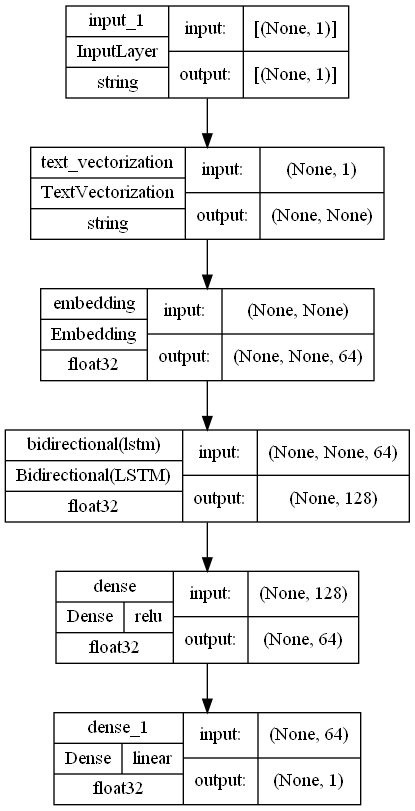

In [19]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True,
                          show_layer_activations=True,
                          show_dtype=True)

In [20]:
sample_text = "the sun was shining and i am in a happy mood."

In [21]:
np.array([sample_text])

array(['the sun was shining and i am in a happy mood.'], dtype='<U45')

In [22]:
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 1s 1s/step


In [23]:
predictions

array([[-0.00069366]], dtype=float32)

In [24]:
print([layer.supports_masking for layer in model.layers])

[True, False, True, True, True, True]


In [25]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss_function = tf.keras.losses.MeanSquaredError()

# not too afraid of the gradients with this dataset
optimizer = tf.keras.optimizers.Adam(0.001)

In [26]:
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [27]:
history = model.fit(x=tf.convert_to_tensor(np.asarray(list(data.keys()))),
                    y=tf.convert_to_tensor(np.asarray(list(data.values()))),
                    validation_data=(list(data_test.keys()), list(data_test.values())),
                    validation_steps=30,
                    epochs=10)

Epoch 1/10
235/235 [==============================] - 10s 29ms/step - loss: 0.3327 - accuracy: 0.8396 - val_loss: 0.1108 - val_accuracy: 0.9660
Epoch 2/10
235/235 [==============================] - 4s 17ms/step - loss: 0.0599 - accuracy: 0.9798 - val_loss: 0.0834 - val_accuracy: 0.9742
Epoch 3/10
235/235 [==============================] - 4s 17ms/step - loss: 0.0350 - accuracy: 0.9872 - val_loss: 0.0931 - val_accuracy: 0.9722
Epoch 4/10
235/235 [==============================] - 4s 18ms/step - loss: 0.0262 - accuracy: 0.9916 - val_loss: 0.1104 - val_accuracy: 0.9670
Epoch 5/10
235/235 [==============================] - 4s 18ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0994 - val_accuracy: 0.9660
Epoch 6/10
235/235 [==============================] - 4s 17ms/step - loss: 0.0160 - accuracy: 0.9943 - val_loss: 0.0900 - val_accuracy: 0.9763
Epoch 7/10
235/235 [==============================] - 4s 18ms/step - loss: 0.0129 - accuracy: 0.9945 - val_loss: 0.1032 - val_accuracy: 0.977

In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.0075997352600097)

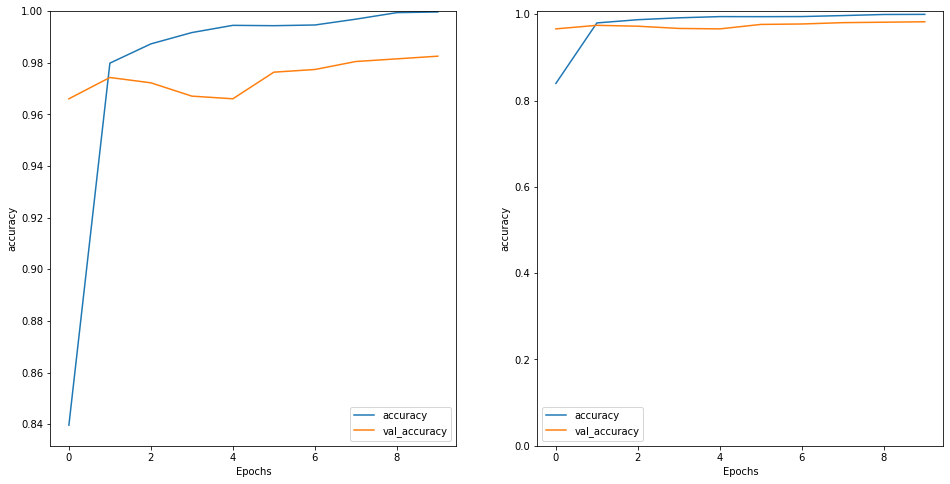

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'accuracy')
plt.ylim(0, None)

In [30]:
model.summary()

Model: "nlp_rnn_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          96000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)          

In [31]:
model.save_weights('./models/joy_and_anger')

In [32]:
model.save('./models/joy_and_anger_entire')

INFO:tensorflow:Assets written to: ./models/joy_and_anger_entire\assets


INFO:tensorflow:Assets written to: ./models/joy_and_anger_entire\assets


In [34]:
model.predict(["great weather were having today"])

1/1 [==============================] - 2s 2s/step


array([[-15.938878]], dtype=float32)

In [35]:
model.predict(["i hate you"])

1/1 [==============================] - 0s 24ms/step


array([[-1.1554629]], dtype=float32)

In [36]:
model.predict(["oh whatever"])

1/1 [==============================] - 0s 23ms/step


array([[0.4448369]], dtype=float32)

In [37]:
model.predict(["cotton candy and ferris wheels"])

1/1 [==============================] - 0s 22ms/step


array([[4.820001]], dtype=float32)

In [39]:
model.predict(["thanks for the support"])

1/1 [==============================] - 0s 24ms/step


array([[-7.112743]], dtype=float32)